# Comparison between Concrete Dropout and Gaussian-prior BNN

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import gc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Create two-moons dataset

In [2]:
from sklearn.datasets import make_moons
x_train, y_train = make_moons(n_samples = 5000, noise = 0.10)
x_test, y_test = make_moons(n_samples = 1000, noise = 0.10)
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)

# Create model using Concrete Dropout

In [3]:
import tensorflow.keras.backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Lambda, Wrapper
from tensorflow.python.ops import random_ops

# Keras layer wrapper to implement Concrete Dropout
class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        self.input_dim = np.prod(input_shape[-1])  # we drop only last dim

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        #unif_noise = random_ops.random_uniform(shape = K.shape(x), dtype=x.dtype)
        p = K.sigmoid(self.p_logit[0])
        drop_prob = (
            K.log(p + eps)
            - K.log(1. - p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        p = K.sigmoid(self.p_logit[0])
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - p)
        dropout_regularizer = p * K.log(p)
        dropout_regularizer += (1. - p) * K.log(1. - p)
        dropout_regularizer *= self.dropout_regularizer * self.input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

def makeModel(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu):
    batch_size = 100
    Nepochs = 500
    train_size = len(x_train)
    L = x_train.shape[1]

    lengthscale = 1e-4
    wd = lengthscale**2/train_size
    dd = 2./train_size
    layers = [100, 50, 5]

    x_in = tf.keras.layers.Input(shape = (L,))
    x = x_in
    for il, l in enumerate(layers):
        x = ConcreteDropout(tf.keras.layers.Dense(l, activation = activation), weight_regularizer = wd, dropout_regularizer = dd)(x)
    if heteroscedatic:
        m = ConcreteDropout(tf.keras.layers.Dense(2, activation = None), weight_regularizer = wd, dropout_regularizer = dd)(x)
    else:
        m = ConcreteDropout(tf.keras.layers.Dense(1, activation = None), weight_regularizer = wd, dropout_regularizer = dd)(x)

    def homoloss(y_true, y_pred):
        mean_ = y_pred[:,0]
        y_ = y_true[:,0]
        return tf.square(y_ - mean_)
    def heteroloss(y_true, y_pred):
        mean_ = y_pred[:,0]
        logvar_ = y_pred[:,1]
        prec_ = tf.exp(-logvar_)
        y_ = y_true[:,0]
        return prec_*tf.square(y_ - mean_) + logvar_

    model = tf.keras.Model(x_in, m)
    if heteroscedatic:
        model.compile(loss = heteroloss, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [])
    else:
        model.compile(loss = homoloss, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [])
    history = model.fit(x_train, y_train,
              epochs = Nepochs,
              batch_size = batch_size,
              shuffle = True,
              validation_data = (x_test, y_test),
              #callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss',
              #                                              min_delta = 0,
              #                                              patience = 5,
              #                                              verbose = 1,
              #                                              mode = 'auto',
              #                                              restore_best_weights = True)]
            )
    p_list = [tf.nn.sigmoid(x) for x in model.trainable_weights if "p_logit" in x.name]
    print("Dropout probabilities:", p_list)
    return model, history


def getMeanStd(model, x_test, Npred = 50):
    pred_m = np.zeros( (len(x_test),) )
    pred_s = np.zeros( (len(x_test),) )
    for i in range(0, Npred):
        tmp = model.predict(x_test)[:,0]
        pred_m += tmp
        pred_s += tmp**2
        del tmp
        gc.collect()
    pred_m /= float(Npred)
    pred_s /= float(Npred)
    pred_s -= pred_m**2
    pred_s[pred_s <= 0] = 1e-6
    pred_s = np.sqrt(pred_s)
        
    return pred_m, pred_s

def getMeanStdH(model, x_test, Npred = 50):
    pred_m = np.zeros( (len(x_test),) )
    pred_s = np.zeros( (len(x_test),) )
    pred_s_ale = 0.5*np.exp(model.predict(x_test)[:,1])
    for i in range(0, Npred):
        tmp = model.predict(x_test)[:,0]
        pred_m += tmp
        pred_s += tmp**2
        del tmp
        gc.collect()
    pred_m /= float(Npred)
    pred_s /= float(Npred)
    pred_s -= pred_m**2
    pred_s[pred_s <= 0] = 1e-6
    pred_s = np.sqrt(pred_s)
    pred_s = np.sqrt(pred_s_ale**2 + pred_s**2)
        
    return pred_m, pred_s



In [4]:
#hetero_model, hetero_model_h = makeModel(x_train, y_train, heteroscedatic = True, activation = tf.nn.relu)
homo_model, homo_model_h = makeModel(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu)

Train on 5000 samples, validate on 1000 samples
Epoch 1/500
5000/5000 [==============================] - 10s 2ms/sample - loss: 0.1929 - val_loss: 0.0961
Epoch 2/500
5000/5000 [==============================] - 2s 388us/sample - loss: 0.0763 - val_loss: 0.0707
Epoch 3/500
5000/5000 [==============================] - 2s 329us/sample - loss: 0.0556 - val_loss: 0.0578
Epoch 4/500
5000/5000 [==============================] - 2s 342us/sample - loss: 0.0475 - val_loss: 0.0415
Epoch 5/500
5000/5000 [==============================] - 1s 283us/sample - loss: 0.0413 - val_loss: 0.0435
Epoch 6/500
5000/5000 [==============================] - 1s 255us/sample - loss: 0.0357 - val_loss: 0.0353
Epoch 7/500
5000/5000 [==============================] - 1s 219us/sample - loss: 0.0321 - val_loss: 0.0273
Epoch 8/500
5000/5000 [==============================] - 1s 277us/sample - loss: 0.0289 - val_loss: 0.0273
Epoch 9/500
5000/5000 [==============================] - 1s 238us/sample - loss: 0.0256 - val_los

5000/5000 [==============================] - 1s 173us/sample - loss: -0.0332 - val_loss: -0.0330
Epoch 150/500
5000/5000 [==============================] - 1s 172us/sample - loss: -0.0341 - val_loss: -0.0329
Epoch 151/500
5000/5000 [==============================] - 1s 152us/sample - loss: -0.0333 - val_loss: -0.0275
Epoch 152/500
5000/5000 [==============================] - 1s 150us/sample - loss: -0.0333 - val_loss: -0.0332
Epoch 153/500
5000/5000 [==============================] - 1s 186us/sample - loss: -0.0339 - val_loss: -0.0333
Epoch 154/500
5000/5000 [==============================] - 1s 172us/sample - loss: -0.0351 - val_loss: -0.0336
Epoch 155/500
5000/5000 [==============================] - 1s 145us/sample - loss: -0.0331 - val_loss: -0.0341
Epoch 156/500
5000/5000 [==============================] - 1s 112us/sample - loss: -0.0359 - val_loss: -0.0357
Epoch 157/500
5000/5000 [==============================] - 1s 169us/sample - loss: -0.0334 - val_loss: -0.0321
Epoch 158/500
5

Epoch 223/500
5000/5000 [==============================] - 1s 135us/sample - loss: -0.0367 - val_loss: -0.0366
Epoch 224/500
5000/5000 [==============================] - 1s 134us/sample - loss: -0.0348 - val_loss: -0.0370
Epoch 225/500
5000/5000 [==============================] - 1s 136us/sample - loss: -0.0384 - val_loss: -0.0311
Epoch 226/500
5000/5000 [==============================] - 1s 157us/sample - loss: -0.0355 - val_loss: -0.0284
Epoch 227/500
5000/5000 [==============================] - 1s 159us/sample - loss: -0.0364 - val_loss: -0.0349
Epoch 228/500
5000/5000 [==============================] - 1s 195us/sample - loss: -0.0351 - val_loss: -0.0376
Epoch 229/500
5000/5000 [==============================] - 1s 116us/sample - loss: -0.0364 - val_loss: -0.0361
Epoch 230/500
5000/5000 [==============================] - 1s 156us/sample - loss: -0.0358 - val_loss: -0.0356
Epoch 231/500
5000/5000 [==============================] - 1s 132us/sample - loss: -0.0362 - val_loss: -0.0365
E

Epoch 297/500
5000/5000 [==============================] - 1s 180us/sample - loss: -0.0372 - val_loss: -0.0386
Epoch 298/500
5000/5000 [==============================] - 1s 200us/sample - loss: -0.0372 - val_loss: -0.0392
Epoch 299/500
5000/5000 [==============================] - 1s 141us/sample - loss: -0.0384 - val_loss: -0.0398
Epoch 300/500
5000/5000 [==============================] - 1s 140us/sample - loss: -0.0381 - val_loss: -0.0371
Epoch 301/500
5000/5000 [==============================] - 1s 131us/sample - loss: -0.0354 - val_loss: -0.0376
Epoch 302/500
5000/5000 [==============================] - 1s 142us/sample - loss: -0.0378 - val_loss: -0.0379
Epoch 303/500
5000/5000 [==============================] - 1s 159us/sample - loss: -0.0368 - val_loss: -0.0378
Epoch 304/500
5000/5000 [==============================] - 1s 143us/sample - loss: -0.0369 - val_loss: -0.0364
Epoch 305/500
5000/5000 [==============================] - 1s 167us/sample - loss: -0.0365 - val_loss: -0.0388
E

Epoch 371/500
5000/5000 [==============================] - 0s 92us/sample - loss: -0.0385 - val_loss: -0.0367
Epoch 372/500
5000/5000 [==============================] - 0s 94us/sample - loss: -0.0370 - val_loss: -0.0397
Epoch 373/500
5000/5000 [==============================] - 0s 87us/sample - loss: -0.0384 - val_loss: -0.0382
Epoch 374/500
5000/5000 [==============================] - 0s 90us/sample - loss: -0.0363 - val_loss: -0.0349
Epoch 375/500
5000/5000 [==============================] - 1s 112us/sample - loss: -0.0391 - val_loss: -0.0374
Epoch 376/500
5000/5000 [==============================] - 1s 129us/sample - loss: -0.0386 - val_loss: -0.0401
Epoch 377/500
5000/5000 [==============================] - 1s 109us/sample - loss: -0.0385 - val_loss: -0.0389
Epoch 378/500
5000/5000 [==============================] - 0s 91us/sample - loss: -0.0384 - val_loss: -0.0399
Epoch 379/500
5000/5000 [==============================] - 0s 92us/sample - loss: -0.0382 - val_loss: -0.0406
Epoch 3

Epoch 445/500
5000/5000 [==============================] - 2s 343us/sample - loss: -0.0386 - val_loss: -0.0386
Epoch 446/500
5000/5000 [==============================] - 2s 305us/sample - loss: -0.0390 - val_loss: -0.0375
Epoch 447/500
5000/5000 [==============================] - 2s 428us/sample - loss: -0.0392 - val_loss: -0.0397
Epoch 448/500
5000/5000 [==============================] - 2s 494us/sample - loss: -0.0381 - val_loss: -0.0373
Epoch 449/500
5000/5000 [==============================] - 3s 527us/sample - loss: -0.0388 - val_loss: -0.0359
Epoch 450/500
5000/5000 [==============================] - 2s 456us/sample - loss: -0.0397 - val_loss: -0.0391
Epoch 451/500
5000/5000 [==============================] - 2s 443us/sample - loss: -0.0373 - val_loss: -0.0384
Epoch 452/500
5000/5000 [==============================] - 2s 467us/sample - loss: -0.0398 - val_loss: -0.0403
Epoch 453/500
5000/5000 [==============================] - 3s 527us/sample - loss: -0.0390 - val_loss: -0.0364
E

# Create Gaussian-prior BNN

In [24]:

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.exp(1e-3)-1.0)
    return tf.keras.Sequential([tfp.layers.VariableLayer(2*n, initializer = 'zeros', trainable = True, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
                           tfp.distributions.Normal(loc=t[..., :n], scale=1e-4+tf.math.softplus(c + 1e-3*t[..., n:])),
                           reinterpreted_batch_ndims=1))
    ])

def prior_fixed(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([tfp.layers.VariableLayer(n, initializer = 'zeros', trainable = False, dtype=dtype),
                                tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
                                tfp.distributions.Normal(loc = t, scale = 100.0), reinterpreted_batch_ndims = 1))
                                ])

def makeModelBNN(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu):
    batch_size = 100
    Nepochs = 1000
    train_size = len(x_train)
    L = x_train.shape[1]

    layers = [100, 50, 5]

    x_in = tf.keras.layers.Input(shape = (L,))
    x = x_in
    for il, l in enumerate(layers):
        x = tfp.layers.DenseVariational(l,
                                        posterior_mean_field,
                                        prior_fixed,
                                        kl_weight = 1.0/train_size,
                                        kl_use_exact = True,
                                        activation = activation,
                                        )(x)
    n_out = 1
    if heteroscedatic:
        n_out = 2
    x = tfp.layers.DenseVariational(n_out,
                                        posterior_mean_field,
                                        prior_fixed,
                                        kl_weight = 1.0/train_size,
                                        kl_use_exact = True,
                                        activation = None,
                                        )(x)
    if heteroscedatic:
        c = np.log(np.exp(1e-3)-1.0)
        x = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t[...,:1],
                                                                    scale = 1e-4 + tf.math.softplus(c+1e-3*t[...,1:])
                                                                        ))(x)
    else:
        x = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t,
                                                                        scale = 1e-4
                                                                        ))(x)

    nll = lambda y_true, y_pred: -tf.reduce_mean(y_pred.log_prob(y_true))
    model = tf.keras.Model(x_in, x)
    model.compile(loss = nll, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [])
    history = model.fit(x_train, y_train,
              epochs = Nepochs,
              batch_size = batch_size,
              shuffle = True,
              validation_data = (x_test, y_test),
              #callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss',
              #                                              min_delta = 0,
              #                                              patience = 5,
              #                                              verbose = 1,
              #                                              mode = 'auto',
              #                                              restore_best_weights = True)]
            )
    return model, history

def getMeanStdBNN(model, x_test, Npred = 50):
    pred_m = np.zeros( (len(x_test),) )
    pred_s = np.zeros( (len(x_test),) )
    for i in range(0, Npred):
        tmp = model.predict(x_test)[:,0]
        pred_m += tmp
        pred_s += tmp**2
        del tmp
        gc.collect()
    pred_m /= float(Npred)
    pred_s /= float(Npred)
    pred_s -= pred_m**2
    pred_s[pred_s <= 0] = 1e-6
    pred_s = np.sqrt(pred_s)
    return pred_m, pred_s

In [25]:
#hetero_model_bnn, hetero_model_bnn_h = makeModelBNN(x_train, y_train, heteroscedatic = True, activation = tf.nn.relu)
homo_model_bnn, homo_model_bnn_h = makeModelBNN(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu)

Train on 5000 samples, validate on 1000 samples
Epoch 1/1000
5000/5000 [==============================] - 19s 4ms/sample - loss: 23018084.7200 - val_loss: 17562784.1000
Epoch 2/1000
5000/5000 [==============================] - 3s 579us/sample - loss: 7533057.5450 - val_loss: 4728576.5750
Epoch 3/1000
5000/5000 [==============================] - 2s 438us/sample - loss: 4353053.5750 - val_loss: 4177144.4250
Epoch 4/1000
5000/5000 [==============================] - 3s 601us/sample - loss: 3992321.1100 - val_loss: 3964664.9750
Epoch 5/1000
5000/5000 [==============================] - 3s 645us/sample - loss: 3754999.2100 - val_loss: 3704828.8000
Epoch 6/1000
5000/5000 [==============================] - 2s 481us/sample - loss: 3576403.1800 - val_loss: 3534212.7250
Epoch 7/1000
5000/5000 [==============================] - 3s 512us/sample - loss: 3408550.7500 - val_loss: 3351103.7750
Epoch 8/1000
5000/5000 [==============================] - 3s 624us/sample - loss: 3186735.4750 - val_loss: 3111

5000/5000 [==============================] - 1s 175us/sample - loss: 183296.5227 - val_loss: 177907.3883
Epoch 138/1000
5000/5000 [==============================] - 1s 163us/sample - loss: 175021.2107 - val_loss: 194156.9031
Epoch 139/1000
5000/5000 [==============================] - 1s 145us/sample - loss: 177170.6301 - val_loss: 169015.2219
Epoch 140/1000
5000/5000 [==============================] - 1s 150us/sample - loss: 194566.0592 - val_loss: 179123.8516
Epoch 141/1000
5000/5000 [==============================] - 1s 158us/sample - loss: 181959.7205 - val_loss: 169987.0820
Epoch 142/1000
5000/5000 [==============================] - 1s 184us/sample - loss: 174950.0255 - val_loss: 175505.9086
Epoch 143/1000
5000/5000 [==============================] - 1s 141us/sample - loss: 168425.0628 - val_loss: 164167.6055
Epoch 144/1000
5000/5000 [==============================] - 1s 159us/sample - loss: 162682.4551 - val_loss: 186411.2719
Epoch 145/1000
5000/5000 [=============================

5000/5000 [==============================] - 1s 129us/sample - loss: 116048.6602 - val_loss: 105455.3379
Epoch 274/1000
5000/5000 [==============================] - 1s 165us/sample - loss: 109498.3833 - val_loss: 108626.4586
Epoch 275/1000
5000/5000 [==============================] - 1s 172us/sample - loss: 111669.9967 - val_loss: 101898.7762
Epoch 276/1000
5000/5000 [==============================] - 1s 165us/sample - loss: 106164.8320 - val_loss: 106503.3484
Epoch 277/1000
5000/5000 [==============================] - 1s 138us/sample - loss: 109739.8405 - val_loss: 114518.2359
Epoch 278/1000
5000/5000 [==============================] - 1s 139us/sample - loss: 110978.7708 - val_loss: 108160.5840
Epoch 279/1000
5000/5000 [==============================] - 1s 159us/sample - loss: 106439.2644 - val_loss: 105971.5980
Epoch 280/1000
5000/5000 [==============================] - 1s 153us/sample - loss: 117873.6618 - val_loss: 101306.9934
Epoch 281/1000
5000/5000 [=============================

Epoch 410/1000
5000/5000 [==============================] - 1s 241us/sample - loss: 96399.5236 - val_loss: 93515.5785
Epoch 411/1000
5000/5000 [==============================] - 1s 217us/sample - loss: 103636.6177 - val_loss: 98848.9541
Epoch 412/1000
5000/5000 [==============================] - 1s 242us/sample - loss: 98364.6678 - val_loss: 115961.2902
Epoch 413/1000
5000/5000 [==============================] - 1s 175us/sample - loss: 102913.1183 - val_loss: 96262.8490
Epoch 414/1000
5000/5000 [==============================] - 1s 155us/sample - loss: 94249.4325 - val_loss: 91774.0053
Epoch 415/1000
5000/5000 [==============================] - 1s 158us/sample - loss: 104127.6940 - val_loss: 113051.5871
Epoch 416/1000
5000/5000 [==============================] - 1s 192us/sample - loss: 93521.3414 - val_loss: 99325.3643
Epoch 417/1000
5000/5000 [==============================] - 1s 212us/sample - loss: 103777.1699 - val_loss: 96645.4812
Epoch 418/1000
5000/5000 [========================

Epoch 479/1000
5000/5000 [==============================] - 3s 586us/sample - loss: 96919.6698 - val_loss: 117053.9418
Epoch 480/1000
5000/5000 [==============================] - 2s 404us/sample - loss: 95130.5038 - val_loss: 96923.2480
Epoch 481/1000
5000/5000 [==============================] - 2s 490us/sample - loss: 87997.7336 - val_loss: 99020.3084
Epoch 482/1000
5000/5000 [==============================] - 2s 351us/sample - loss: 91449.1137 - val_loss: 93612.7945
Epoch 483/1000
5000/5000 [==============================] - 2s 348us/sample - loss: 91020.3587 - val_loss: 107371.0883
Epoch 484/1000
5000/5000 [==============================] - 2s 413us/sample - loss: 94256.4049 - val_loss: 86611.7357
Epoch 485/1000
5000/5000 [==============================] - 2s 395us/sample - loss: 90917.0533 - val_loss: 89999.4635
Epoch 486/1000
5000/5000 [==============================] - 2s 438us/sample - loss: 88844.7987 - val_loss: 107526.9822
Epoch 487/1000
5000/5000 [===========================

5000/5000 [==============================] - 2s 355us/sample - loss: 88090.1585 - val_loss: 100107.3863
Epoch 618/1000
5000/5000 [==============================] - 2s 409us/sample - loss: 82955.4435 - val_loss: 89265.4469
Epoch 619/1000
5000/5000 [==============================] - 2s 448us/sample - loss: 98351.9207 - val_loss: 97888.7279
Epoch 620/1000
5000/5000 [==============================] - 2s 447us/sample - loss: 80564.0997 - val_loss: 94688.9547
Epoch 621/1000
5000/5000 [==============================] - 2s 369us/sample - loss: 85340.3976 - val_loss: 95690.6721
Epoch 622/1000
5000/5000 [==============================] - 2s 394us/sample - loss: 84515.6496 - val_loss: 110588.6271
Epoch 623/1000
5000/5000 [==============================] - 1s 264us/sample - loss: 86761.1199 - val_loss: 93018.1439
Epoch 624/1000
5000/5000 [==============================] - 2s 355us/sample - loss: 80661.2200 - val_loss: 82581.7615
Epoch 625/1000
5000/5000 [==============================] - 2s 374us/

5000/5000 [==============================] - 2s 357us/sample - loss: 79817.3796 - val_loss: 81356.3743
Epoch 756/1000
5000/5000 [==============================] - 2s 389us/sample - loss: 74868.7919 - val_loss: 77751.4807
Epoch 757/1000
5000/5000 [==============================] - 2s 391us/sample - loss: 74805.0199 - val_loss: 78952.8888
Epoch 758/1000
5000/5000 [==============================] - 2s 379us/sample - loss: 77445.6095 - val_loss: 88786.9543
Epoch 759/1000
5000/5000 [==============================] - 2s 374us/sample - loss: 80361.1862 - val_loss: 89135.3594
Epoch 760/1000
5000/5000 [==============================] - 2s 334us/sample - loss: 80045.0446 - val_loss: 85869.7129
Epoch 761/1000
5000/5000 [==============================] - 2s 395us/sample - loss: 84539.0112 - val_loss: 79141.9405
Epoch 762/1000
5000/5000 [==============================] - 1s 298us/sample - loss: 80271.6562 - val_loss: 102509.0891
Epoch 763/1000
5000/5000 [==============================] - 2s 430us/s

5000/5000 [==============================] - 2s 369us/sample - loss: 79598.1766 - val_loss: 77597.8027
Epoch 894/1000
5000/5000 [==============================] - 2s 314us/sample - loss: 71764.7341 - val_loss: 79696.3457
Epoch 895/1000
5000/5000 [==============================] - 1s 286us/sample - loss: 83568.3149 - val_loss: 83642.3192
Epoch 896/1000
5000/5000 [==============================] - 2s 345us/sample - loss: 74792.6326 - val_loss: 79934.9138
Epoch 897/1000
5000/5000 [==============================] - 1s 268us/sample - loss: 70639.7738 - val_loss: 77624.6647
Epoch 898/1000
5000/5000 [==============================] - 1s 253us/sample - loss: 75822.6609 - val_loss: 73425.2262
Epoch 899/1000
5000/5000 [==============================] - 2s 323us/sample - loss: 80436.1728 - val_loss: 100077.2465
Epoch 900/1000
5000/5000 [==============================] - 1s 246us/sample - loss: 83002.1563 - val_loss: 89569.0833
Epoch 901/1000
5000/5000 [==============================] - 1s 248us/s

# Function to do plots showing mean and uncertainties

In [7]:
def plot_contour(model, x, y, getFunction):
    # make countour
    mins = [np.min(x[:,0]), np.min(x[:,1])]
    maxs = [np.max(x[:,0]), np.max(x[:,1])]
    step = [(maxs[0] - mins[0])/50.0, (maxs[1] - mins[1])/50.0]
    bx, by = np.mgrid[mins[0]:(maxs[0]+0.5*step[0]):step[0], mins[1]:(maxs[1]+0.5*step[0]):step[1]]
    inputs = np.vstack([bx.flatten(), by.flatten()]).T
    inputs = inputs.astype(np.float32)

    pred_m, pred_s = getFunction(model, inputs, Npred = 50)
    pred_m_2d = pred_m.reshape( (-1, bx.shape[1]) )
    pred_s_2d = pred_s.reshape( (-1, bx.shape[1]) )

    # if one wants to smoothen the results
    #for data in [pred_m_2d, pred_s_2d]:
    #    data = gaussian_filter(data, 0.1)

    fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10, 8))
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    contour_s = ax[0].contourf(bx, by, pred_s_2d, cmap = cmap)
    cbar_s = plt.colorbar(contour_s, ax = ax[0])
    cbar_s.ax.set_ylabel('Unc.')
    contour_m = ax[1].contourf(bx, by, pred_m_2d, cmap = cmap)
    cbar_m = plt.colorbar(contour_m, ax = ax[1])
    cbar_m.ax.set_ylabel('Mean')
    for a in [ax[0], ax[1]]:
        a.scatter(x[y == 1,0], x[y == 1,1], color = 'r', marker = 's', s = 5, label = 'y = 1')
        a.scatter(x[y == 0,0], x[y == 0,1], color = 'b', marker = 's', s = 5, label = 'y = 0')
        a.set(xlabel = 'A', ylabel = 'B', title = '')
        a.set_xlim([mins[0], maxs[0]])
        a.set_ylim([mins[1], maxs[1]])
        a.legend(frameon = True)
    ax[0].set_xlabel('')
    fig.subplots_adjust(hspace = 0)
    fig.tight_layout()
    plt.show()


In [14]:
def plot_loss(h):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(len(h.history['loss'])), h.history['loss'])
    plt.title('')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# Countour for heteroscedatic Concrete Dropout model

In [8]:
#plot_contour(hetero_model, x_test, y_test, getFunction = getMeanStdH)


# Contour for homoscedatic Concrete Dropout model

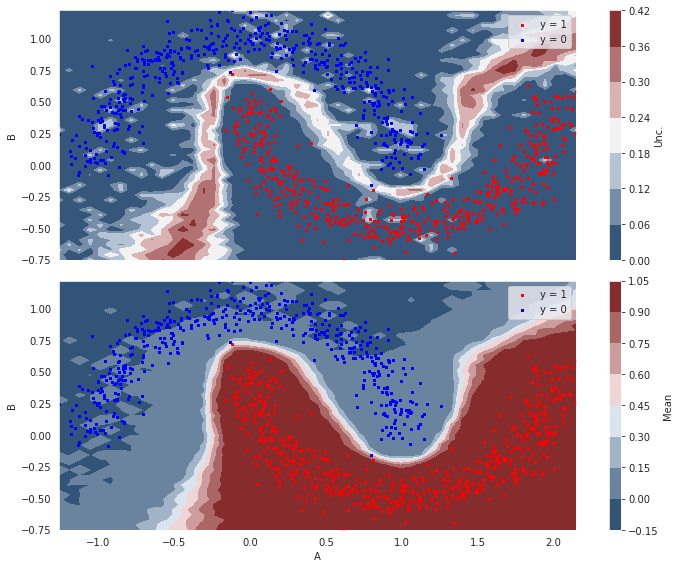

In [9]:
plot_contour(homo_model, x_test, y_test, getFunction = getMeanStd)


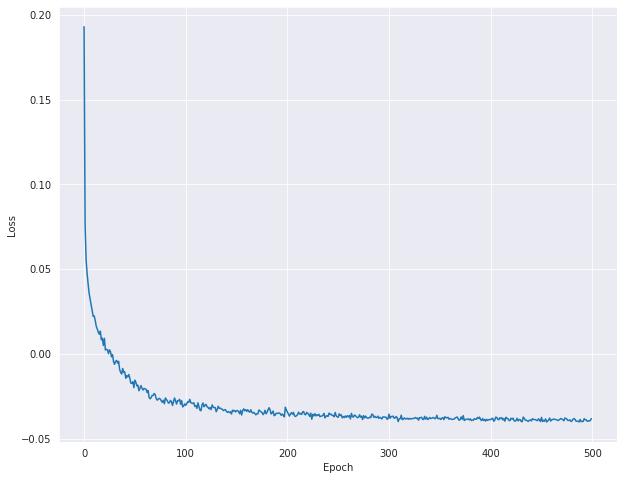

In [15]:
plot_loss(homo_model_h)

# Contour for heteroscedatic Gaussian-prior BNN model

In [10]:
#plot_contour(hetero_model_bnn, x_test, y_test, getFunction = getMeanStdBNN)


# Contour for homoscedatic Gaussian-prior BNN model

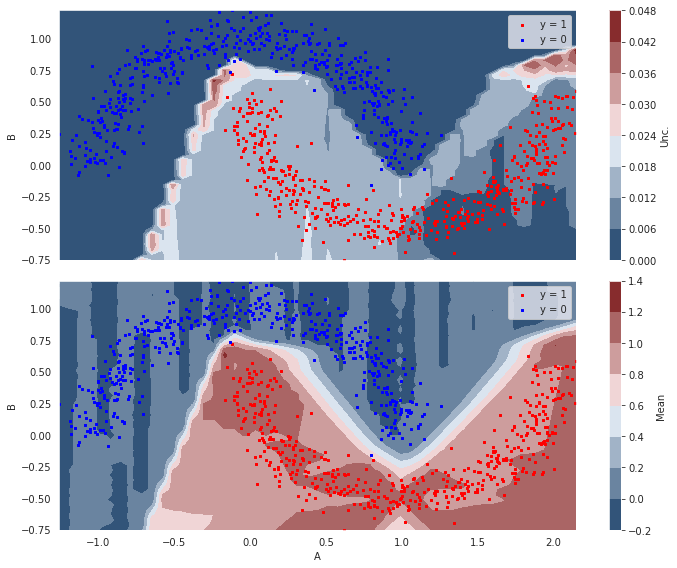

In [26]:
plot_contour(homo_model_bnn, x_test, y_test, getFunction = getMeanStdBNN)


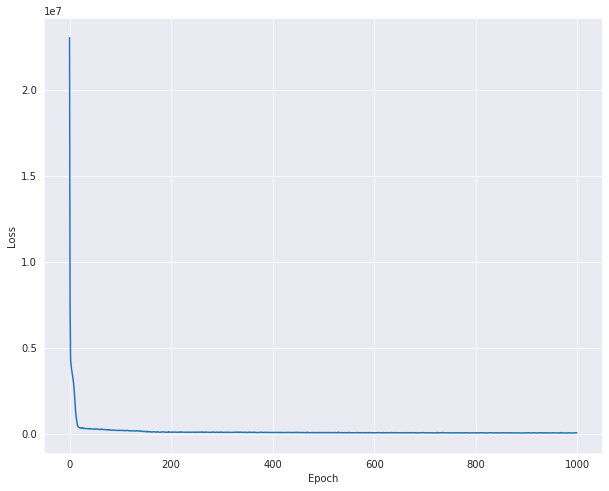

In [27]:
plot_loss(homo_model_bnn_h)